In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 3.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.2 MB/s eta 0:00:00


In [2]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

In [8]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

In [12]:
## retry
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [15]:
%load_ext sql
%sql sqlite:///sample.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


**Create Tables with feed them with dummy data**

In [20]:
%%sql
-- Create the 'products' table
CREATE TABLE IF NOT EXISTS products (
  	product_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	product_name VARCHAR(255) NOT NULL,
  	price DECIMAL(10, 2) NOT NULL
  );

-- Create the 'staff' table
CREATE TABLE IF NOT EXISTS staff (
  	staff_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	first_name VARCHAR(255) NOT NULL,
  	last_name VARCHAR(255) NOT NULL
  );

-- Create the 'orders' table
CREATE TABLE IF NOT EXISTS orders (
  	order_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	customer_name VARCHAR(255) NOT NULL,
  	staff_id INTEGER NOT NULL,
  	product_id INTEGER NOT NULL,
  	FOREIGN KEY (staff_id) REFERENCES staff (staff_id),
  	FOREIGN KEY (product_id) REFERENCES products (product_id)
  );

-- Insert data into the 'products' table
INSERT INTO products (product_name, price) VALUES
  	('Laptop', 799.99),
  	('Keyboard', 129.99),
  	('Mouse', 29.99);

-- Insert data into the 'staff' table
INSERT INTO staff (first_name, last_name) VALUES
  	('Alice', 'Smith'),
  	('Bob', 'Johnson'),
  	('Charlie', 'Williams');

-- Insert data into the 'orders' table
INSERT INTO orders (customer_name, staff_id, product_id) VALUES
  	('David Lee', 1, 1),
  	('Emily Chen', 2, 2),
  	('Frank Brown', 1, 3);


 * sqlite:///sample.db
Done.
Done.
Done.
3 rows affected.
3 rows affected.
3 rows affected.


[]

**Define database functions**

In [21]:
import sqlite3

db_file = "sample.db"
db_conn = sqlite3.connect(db_file)

In [22]:
def list_tables() -> list[str]:
    """Retrieve the names of all tables in the database."""
    # Include print logging statements so you can see when functions are being called.
    print(' - DB CALL: list_tables()')

    cursor = db_conn.cursor()

    # Fetch the table names.
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    return [t[0] for t in tables]


list_tables()

 - DB CALL: list_tables()


['products', 'sqlite_sequence', 'staff', 'orders']

In [23]:
def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema.

    Returns:
      List of columns, where each entry is a tuple of (column, type).
    """
    print(f' - DB CALL: describe_table({table_name})')

    cursor = db_conn.cursor()

    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()
    # [column index, column name, column type, ...]
    return [(col[1], col[2]) for col in schema]


describe_table("products")

 - DB CALL: describe_table(products)


[('product_id', 'INTEGER'),
 ('product_name', 'VARCHAR(255)'),
 ('price', 'DECIMAL(10, 2)')]

In [24]:
def execute_query(sql: str) -> list[list[str]]:
    """Execute an SQL statement, returning the results."""
    print(f' - DB CALL: execute_query({sql})')

    cursor = db_conn.cursor()

    cursor.execute(sql)
    return cursor.fetchall()


execute_query("select * from products")

 - DB CALL: execute_query(select * from products)


[(1, 'Laptop', 799.99), (2, 'Keyboard', 129.99), (3, 'Mouse', 29.99)]

**Implement function calls**

In [25]:
# These are the Python functions defined above.
db_tools = [list_tables, describe_table, execute_query]

instruction = """You are a helpful chatbot that can interact with an SQL database
for a computer store. You will take the users questions and turn them into SQL
queries using the tools available. Once you have the information you need, you will
answer the user's question using the data returned.

Use list_tables to see what tables are present, describe_table to understand the
schema, and execute_query to issue an SQL SELECT query."""

client = genai.Client(api_key=GOOGLE_API_KEY)

# Start a chat with automatic function calling enabled.
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)

In [26]:
resp = chat.send_message("What is the cheapest product?")
print(f"\n{resp.text}")

 - DB CALL: list_tables()
 - DB CALL: describe_table(products)
 - DB CALL: execute_query(SELECT product_name, price FROM products ORDER BY price ASC LIMIT 1)

The cheapest product is the Mouse, which costs $29.99.


In [27]:
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)

response = chat.send_message('What products should salesperson Alice focus on to round out her portfolio? Explain why.')
print(f"\n{response.text}")

 - DB CALL: list_tables()
 - DB CALL: describe_table(products)
 - DB CALL: describe_table(staff)
 - DB CALL: describe_table(orders)
 - DB CALL: execute_query(SELECT staff_id FROM staff WHERE first_name = 'Alice')
 - DB CALL: execute_query(SELECT DISTINCT product_id FROM orders WHERE staff_id = 1)
 - DB CALL: execute_query(SELECT product_id FROM products)
 - DB CALL: execute_query(SELECT product_name FROM products WHERE product_id = 2)

Alice should focus on selling Keyboards, as she has not sold any yet.



Inspecting the conversation

In [28]:
import textwrap


def print_chat_turns(chat):
    """Prints out each turn in the chat history, including function calls and responses."""
    for event in chat.get_history():
        print(f"{event.role.capitalize()}:")

        for part in event.parts:
            if txt := part.text:
                print(f'  "{txt}"')
            elif fn := part.function_call:
                args = ", ".join(f"{key}={val}" for key, val in fn.args.items())
                print(f"  Function call: {fn.name}({args})")
            elif resp := part.function_response:
                print("  Function response:")
                print(textwrap.indent(str(resp.response['result']), "    "))

        print()


print_chat_turns(chat)

User:
  "What products should salesperson Alice focus on to round out her portfolio? Explain why."

Model:
  Function call: list_tables()

User:
  Function response:
    ['products', 'sqlite_sequence', 'staff', 'orders']

Model:
  "Okay, I see tables named products, staff, orders, and sqlite_sequence. I'll start by describing the products and staff tables to understand their structure.
"
  Function call: describe_table(table_name=products)
  Function call: describe_table(table_name=staff)

User:
  Function response:
    [('product_id', 'INTEGER'), ('product_name', 'VARCHAR(255)'), ('price', 'DECIMAL(10, 2)')]
  Function response:
    [('staff_id', 'INTEGER'), ('first_name', 'VARCHAR(255)'), ('last_name', 'VARCHAR(255)')]

Model:
  "Okay, the products table has product_id, product_name, and price. The staff table has staff_id, first_name, and last_name. Now I need to figure out how to connect Alice's sales to the products. I'll describe the orders table to see if it links staff and prod

**Compositional function calling**

The feature requires the Live API, so this step uses different setup code than most of the examples you have seen so far. As the Multimodal Live API is a bi-directional streaming service, everything is set up in advance and then executed. This is a little more complex but the result is quite powerful.

In [29]:
from pprint import pformat
from IPython.display import display, Image, Markdown


async def handle_response(stream, tool_impl=None):
  """Stream output and handle any tool calls during the session."""
  all_responses = []

  async for msg in stream.receive():
    all_responses.append(msg)

    if text := msg.text:
      # Output any text chunks that are streamed back.
      if len(all_responses) < 2 or not all_responses[-2].text:
        # Display a header if this is the first text chunk.
        display(Markdown('### Text'))

      print(text, end='')

    elif tool_call := msg.tool_call:
      # Handle tool-call requests.
      for fc in tool_call.function_calls:
        display(Markdown('### Tool call'))

        # Execute the tool and collect the result to return to the model.
        if callable(tool_impl):
          try:
            result = tool_impl(**fc.args)
          except Exception as e:
            result = str(e)
        else:
          result = 'ok'

        tool_response = types.LiveClientToolResponse(
            function_responses=[types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': result},
            )]
        )
        await stream.send(input=tool_response)

    elif msg.server_content and msg.server_content.model_turn:
      # Print any messages showing code the model generated and ran.

      for part in msg.server_content.model_turn.parts:
          if code := part.executable_code:
            display(Markdown(
                f'### Code\n```\n{code.code}\n```'))

          elif result := part.code_execution_result:
            display(Markdown(f'### Result: {result.outcome}\n'
                             f'```\n{pformat(result.output)}\n```'))

          elif img := part.inline_data:
            display(Image(img.data))

  print()
  return all_responses

In [30]:
model = 'gemini-2.0-flash-exp'
live_client = genai.Client(api_key=GOOGLE_API_KEY,
                           http_options=types.HttpOptions(api_version='v1alpha'))

# Wrap the existing execute_query tool you used in the earlier example.
execute_query_tool_def = types.FunctionDeclaration.from_callable(
    client=live_client, callable=execute_query)

# Provide the model with enough information to use the tool, such as describing
# the database so it understands which SQL syntax to use.
sys_int = """You are a database interface. Use the `execute_query` function
to answer the users questions by looking up information in the database,
running any necessary queries and responding to the user.

You need to look up table schema using sqlite3 syntax SQL, then once an
answer is found be sure to tell the user. If the user is requesting an
action, you must also execute the actions.
"""

config = {
    "response_modalities": ["TEXT"],
    "system_instruction": {"parts": [{"text": sys_int}]},
    "tools": [
        {"code_execution": {}},
        {"function_declarations": [execute_query_tool_def.to_json_dict()]},
    ],
}

async with live_client.aio.live.connect(model=model, config=config) as session:

  message = "Please generate and insert 5 new rows in the orders table."
  print(f"> {message}\n")

  await session.send(input=message, end_of_turn=True)
  await handle_response(session, tool_impl=execute_query)


<ipython-input-30-1d6db7aa9025>:29: ExperimentalWarning: The live API is experimental and may change in future versions.
  async with live_client.aio.live.connect(model=model, config=config) as session:


> Please generate and insert 5 new rows in the orders table.



### Text

I need to understand the structure of the `orders` table before I can insert new rows. I'll start by querying the database schema.


### Code
```
print(default_api.execute_query(sql="PRAGMA table_info(orders);"))

```

### Tool call

 - DB CALL: execute_query(PRAGMA table_info(orders);)


### Result: OUTCOME_OK
```
("{'result': [[0, 'order_id', 'INTEGER', 0, None, 1], [1, 'customer_name', "
 "'VARCHAR(255)', 1, None, 0], [2, 'staff_id', 'INTEGER', 1, None, 0], [3, "
 "'product_id', 'INTEGER', 1, None, 0]]}\n")
```

### Text

Okay, the `orders` table has columns `order_id` (INTEGER, primary key), `customer_name` (VARCHAR(255)), `staff_id` (INTEGER), and `product_id` (INTEGER). I'll now insert 5 new rows into this table, making sure to provide values for `customer_name`, `staff_id`, and `product_id`. I will auto-increment the `order_id`.


### Code
```
insert_statements = [
    "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Alice Smith', 1, 101);",
    "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Bob Johnson', 2, 102);",
    "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Charlie Brown', 1, 103);",
    "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Diana Prince', 3, 104);",
    "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Eve Miller', 2, 105);"
]

for stmt in insert_statements:
  print(default_api.execute_query(sql=stmt))

```

### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Alice Smith', 1, 101);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Bob Johnson', 2, 102);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Charlie Brown', 1, 103);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Diana Prince', 3, 104);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Eve Miller', 2, 105);)


### Result: OUTCOME_OK
```
("{'result': []}\n"
 "{'result': []}\n"
 "{'result': []}\n"
 "{'result': []}\n"
 "{'result': []}\n")
```

### Text

I have successfully inserted 5 new rows into the `orders` table.



**Plotting the database using liveclient**

> Can you figure out the number of orders that were made by each of the staff?



### Code
```
sql_query = "SELECT name FROM sqlite_master WHERE type='table';"
print(default_api.execute_query(sql=sql_query))

```

### Tool call

 - DB CALL: execute_query(SELECT name FROM sqlite_master WHERE type='table';)


### Result: OUTCOME_OK
```
"{'result': [['products'], ['sqlite_sequence'], ['staff'], ['orders']]}\n"
```

### Text

Okay, I see the tables available are `products`, `staff`, and `orders`. To figure out the number of orders made by each staff, I'll need to join the `staff` and `orders` tables, probably using a staff ID. Let's inspect the schemas of both tables.


### Code
```
print(default_api.execute_query(sql="PRAGMA table_info(staff);"))
print(default_api.execute_query(sql="PRAGMA table_info(orders);"))

```

### Tool call

 - DB CALL: execute_query(PRAGMA table_info(staff);)


### Tool call

 - DB CALL: execute_query(PRAGMA table_info(orders);)


### Result: OUTCOME_OK
```
("{'result': [[0, 'staff_id', 'INTEGER', 0, None, 1], [1, 'first_name', "
 "'VARCHAR(255)', 1, None, 0], [2, 'last_name', 'VARCHAR(255)', 1, None, 0]]}\n"
 "{'result': [[0, 'order_id', 'INTEGER', 0, None, 1], [1, 'customer_name', "
 "'VARCHAR(255)', 1, None, 0], [2, 'staff_id', 'INTEGER', 1, None, 0], [3, "
 "'product_id', 'INTEGER', 1, None, 0]]}\n")
```

### Text

Okay, it seems like `staff` table has `staff_id`, `first_name`, and `last_name` columns, and the `orders` table has `order_id`, `customer_name`, `staff_id`, and `product_id`.  I can join these tables on `staff.staff_id = orders.staff_id`. Then I will group by `staff_id` and count the number of orders to fulfill the user request. I will also select `first_name` and `last_name` to show to the user.


### Code
```
sql_query = """
SELECT
    s.first_name,
    s.last_name,
    COUNT(o.order_id) AS number_of_orders
FROM
    staff s
JOIN
    orders o ON s.staff_id = o.staff_id
GROUP BY
    s.staff_id;
"""
print(default_api.execute_query(sql=sql_query))

```

### Tool call

 - DB CALL: execute_query(
SELECT
    s.first_name,
    s.last_name,
    COUNT(o.order_id) AS number_of_orders
FROM
    staff s
JOIN
    orders o ON s.staff_id = o.staff_id
GROUP BY
    s.staff_id;
)


### Result: OUTCOME_OK
```
("{'result': [['Alice', 'Smith', 4], ['Bob', 'Johnson', 3], ['Charlie', "
 "'Williams', 1]]}\n")
```

### Text

Okay, it looks like:
- Alice Smith made 4 orders.
- Bob Johnson made 3 orders.
- Charlie Williams made 1 order.

> Generate and run some code to plot this as a python seaborn chart



### Text

I need to retrieve the data again to plot it using seaborn.


### Code
```
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sql_query = """
SELECT
    s.first_name,
    s.last_name,
    COUNT(o.order_id) AS number_of_orders
FROM
    staff s
JOIN
    orders o ON s.staff_id = o.staff_id
GROUP BY
    s.staff_id;
"""
result = default_api.execute_query(sql=sql_query)
df = pd.DataFrame(result['result'], columns=['first_name', 'last_name', 'number_of_orders'])
df['staff_name'] = df['first_name'] + ' ' + df['last_name']

plt.figure(figsize=(10,6))
sns.barplot(x='staff_name', y='number_of_orders', data=df)
plt.xlabel('Staff Name')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per Staff')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

```

### Tool call

 - DB CALL: execute_query(
SELECT
    s.first_name,
    s.last_name,
    COUNT(o.order_id) AS number_of_orders
FROM
    staff s
JOIN
    orders o ON s.staff_id = o.staff_id
GROUP BY
    s.staff_id;
)


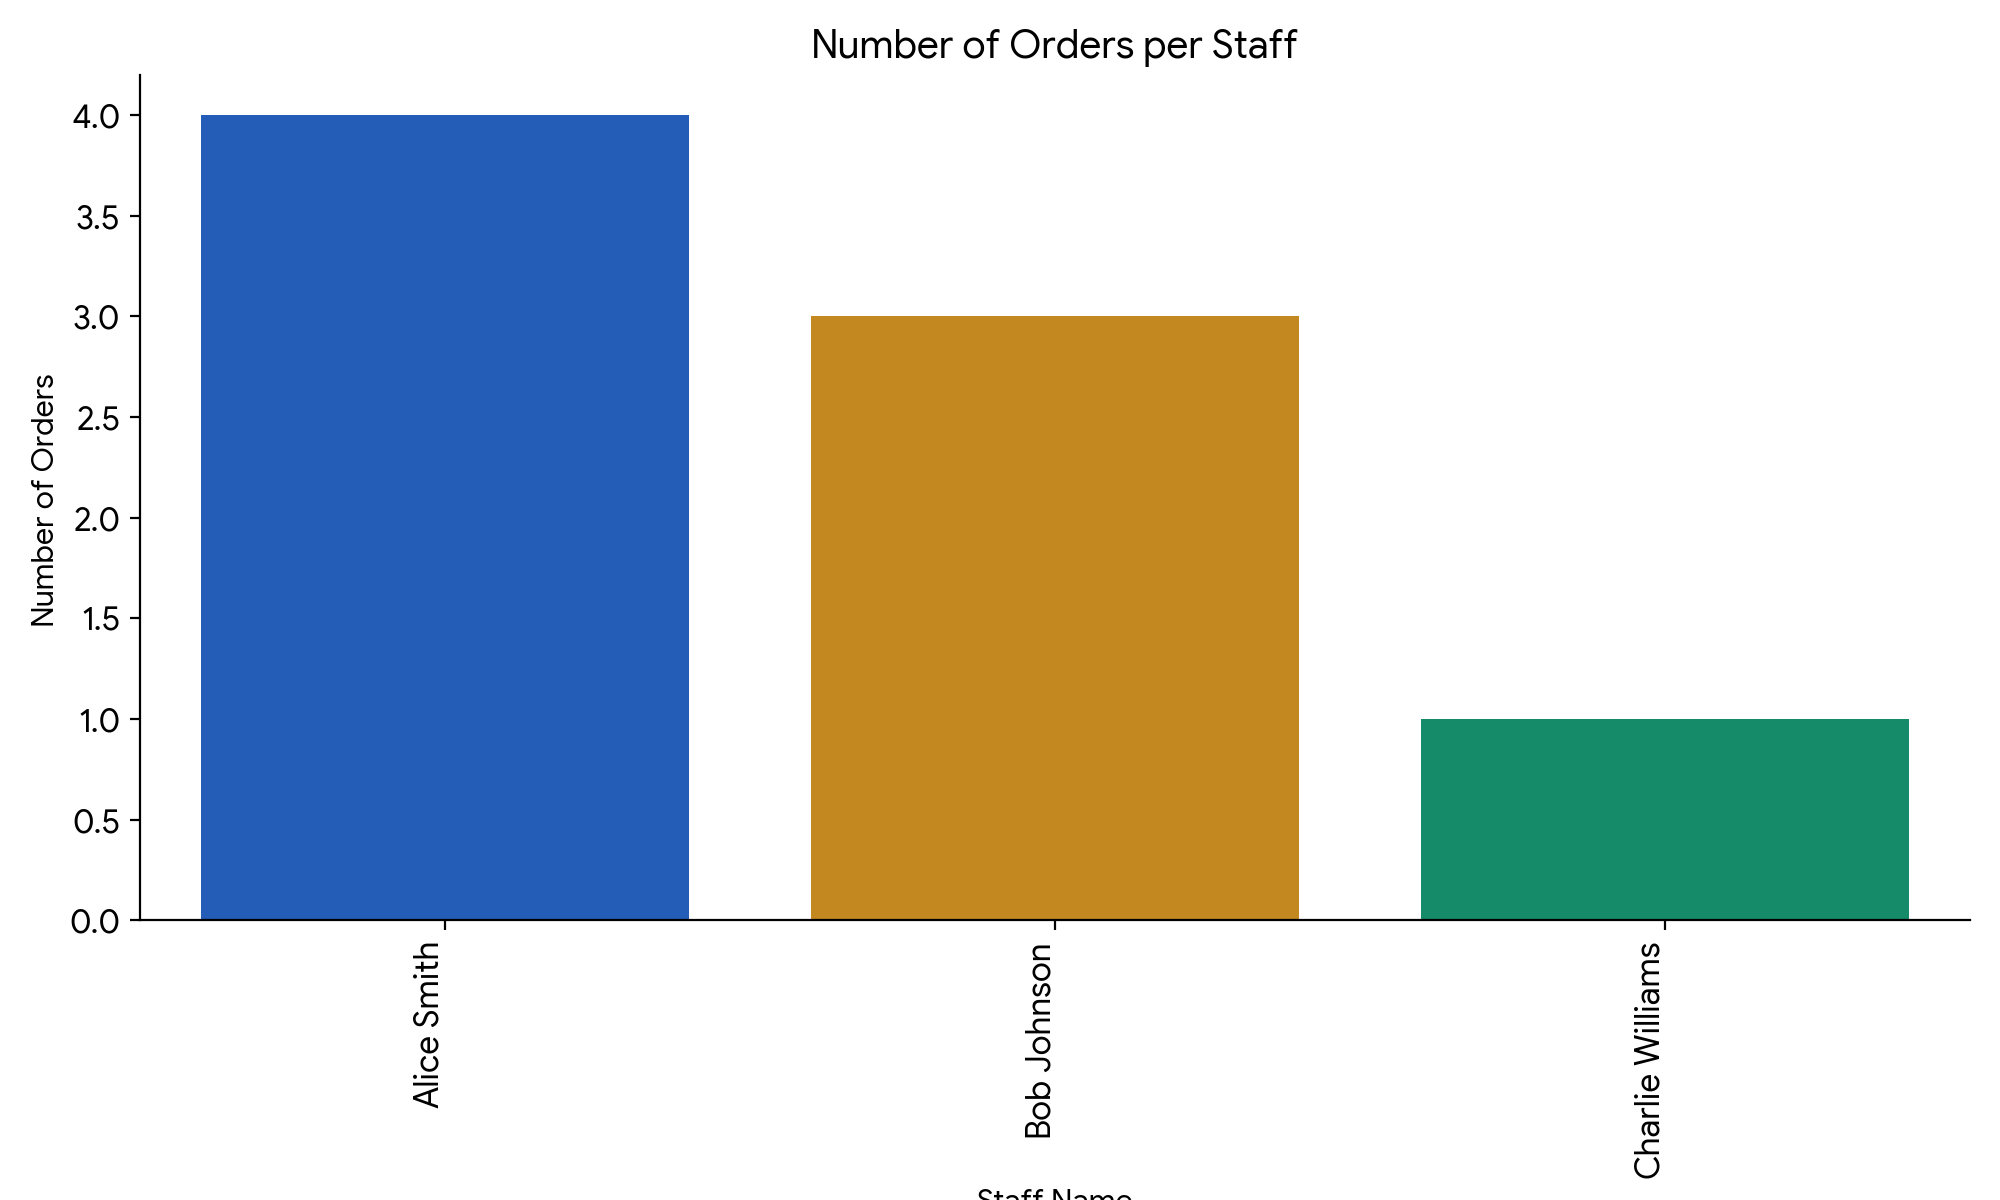

### Text

Okay, the plot is generated and shows the number of orders per staff member. Alice Smith has the most orders with 4, followed by Bob Johnson with 3 and Charlie Williams with 1.



In [31]:
async with live_client.aio.live.connect(model=model, config=config) as session:

  message = "Can you figure out the number of orders that were made by each of the staff?"

  print(f"> {message}\n")
  await session.send(input=message, end_of_turn=True)
  await handle_response(session, tool_impl=execute_query)

  message = "Generate and run some code to plot this as a python seaborn chart"

  print(f"> {message}\n")
  await session.send(input=message, end_of_turn=True)
  await handle_response(session, tool_impl=execute_query)